In [1]:
pip install pm4py


     ---------------------------------------- 0.0/278.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/278.7 kB 660.6 kB/s eta 0:00:01
     --------------- ---------------------- 112.6/278.7 kB 1.3 MB/s eta 0:00:01
     -------------------------------------  276.5/278.7 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 278.7/278.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.1 MB 3.5 MB/s eta 0:00:01
   ------ --------------------------------- 0.4/2.1 MB 3.8 MB/s eta 0:00:01
   ---------- ----------------------------- 0.6/2.1 MB 4.4 MB/s eta 0:00:01
   -------------- ------------------------- 0.8/2.1 MB 4.4 MB/s eta 0:00:01
   ------------------ --------------------- 1.0/2.1 MB 4.4 MB/s eta 0:00:01
   ---------------------- ----------------- 1.2/2.1 MB 4

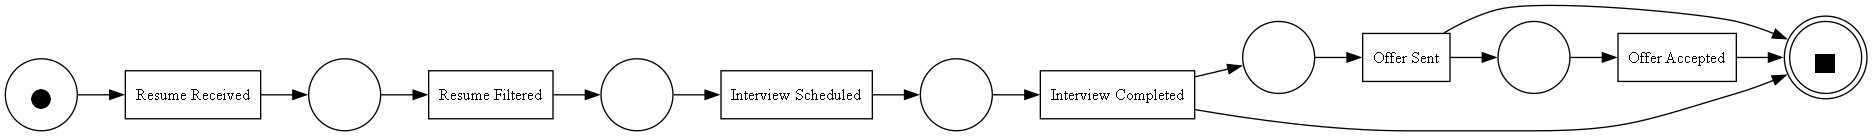

In [2]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# 讀取 CSV
df = pd.read_csv("./simulated_resume_event_log.csv")
df.columns = ["case:concept:name", "concept:name", "time:timestamp", "org:resource"]
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])

# 處理 dataframe，轉換為事件日誌
df = dataframe_utils.convert_timestamp_columns_in_df(df)
log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

# 探勘流程模型（Alpha Miner）
net, im, fm = alpha_miner.apply(log)

# 視覺化 Petri Net
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


In [8]:
import pandas as pd

# 重新整理事件資料
df = pd.read_csv("simulated_resume_event_log.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 計算每個 case_id 各活動之間的時間差
df = df.sort_values(by=["resume_id", "timestamp"])
df["next_activity"] = df.groupby("resume_id")["activity"].shift(-1)
df["next_timestamp"] = df.groupby("resume_id")["timestamp"].shift(-1)
df["duration"] = (df["next_timestamp"] - df["timestamp"]).dt.total_seconds()

# 過濾掉最後一個活動（沒有下一步）
filtered = df.dropna(subset=["next_activity", "duration"])

# 計算平均耗時（以當下活動為準）
avg_duration = filtered.groupby("activity")["duration"].mean().round(2)

# 顯示結果
print("各活動平均停留時間（秒）：")
print(avg_duration)


各活動平均停留時間（秒）：
activity
Interview Completed    7994.12
Interview Scheduled    8058.00
Offer Sent             8096.25
Resume Filtered        8327.70
Resume Received        7740.00
Name: duration, dtype: float64


In [9]:
from pm4py.statistics.traces.generic.log import case_statistics

variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

print("流程變異 Top 5：")
for var in variants_count[:5]:
    print(f"流程路徑: {var['variant']} - 次數: {var['count']}")


流程變異 Top 5：
流程路徑: ('Resume Received', 'Resume Filtered', 'Interview Scheduled', 'Interview Completed', 'Offer Sent') - 次數: 72
流程路徑: ('Resume Received', 'Resume Filtered', 'Interview Scheduled', 'Interview Completed', 'Offer Sent', 'Offer Accepted') - 次數: 64
流程路徑: ('Resume Received', 'Resume Filtered', 'Interview Scheduled', 'Interview Completed') - 次數: 64
